In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch.nn.functional as F
import numpy as np
import pandas as pd
from math import ceil
from numpy import load

In [3]:
def load_emb_data(file_name):
    # load dict of arrays
    dict_data = load(f"../../data/processed/{file_name}.npz")
    # extract the first array
    return dict_data['arr_0']

In [43]:
# load dict of arrays
title_vec = load_emb_data("combine_title")
feature_vec = load_emb_data("combine_feature")
label = load_emb_data("combine_label")
index = load_emb_data("combine_index")

# Inputs and target
inputs = np.hstack([title_vec, feature_vec])
targets = label

In [44]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.dense1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dense2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.dense2(lstm_out)
        return out

# Hyperparameters
input_size = inputs.shape[1]
hidden_size = 128
num_classes = 3
num_epochs = 40
learning_rate = 0.0005

In [45]:
# Convert to PyTorch tensors
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.long)

# Create dataset
dataset = TensorDataset(inputs, targets)

# Split dataset into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [46]:
# Initialize the model, loss function, and optimizer
model = ClassificationModel(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_loss = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation loop
model.eval()
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy and F1 score
accuracy = accuracy_score(all_targets, all_predictions)
f1 = f1_score(all_targets, all_predictions, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


Epoch [1/40], Loss: 0.2042
Epoch [2/40], Loss: 0.2354
Epoch [3/40], Loss: 0.3010
Epoch [4/40], Loss: 0.4075
Epoch [5/40], Loss: 0.3850
Epoch [6/40], Loss: 0.2281
Epoch [7/40], Loss: 0.1074
Epoch [8/40], Loss: 0.1870
Epoch [9/40], Loss: 0.2244
Epoch [10/40], Loss: 0.0347
Epoch [11/40], Loss: 0.2615
Epoch [12/40], Loss: 0.2968
Epoch [13/40], Loss: 0.3098
Epoch [14/40], Loss: 0.4263
Epoch [15/40], Loss: 0.0522
Epoch [16/40], Loss: 0.0982
Epoch [17/40], Loss: 0.3295
Epoch [18/40], Loss: 0.4266
Epoch [19/40], Loss: 0.0222
Epoch [20/40], Loss: 0.3130
Epoch [21/40], Loss: 0.0555
Epoch [22/40], Loss: 0.0486
Epoch [23/40], Loss: 0.0858
Epoch [24/40], Loss: 0.1097
Epoch [25/40], Loss: 0.2083
Epoch [26/40], Loss: 0.0575
Epoch [27/40], Loss: 0.1773
Epoch [28/40], Loss: 0.1987
Epoch [29/40], Loss: 0.0862
Epoch [30/40], Loss: 0.0679
Epoch [31/40], Loss: 0.0658
Epoch [32/40], Loss: 0.2251
Epoch [33/40], Loss: 0.0539
Epoch [34/40], Loss: 0.0298
Epoch [35/40], Loss: 0.2244
Epoch [36/40], Loss: 0.0632
E

In [47]:
model, sum(p.numel() for p in model.parameters())

(ClassificationModel(
   (dense1): Linear(in_features=1536, out_features=128, bias=True)
   (dropout): Dropout(p=0.3, inplace=False)
   (lstm): LSTM(128, 128, batch_first=True)
   (dense2): Linear(in_features=128, out_features=3, bias=True)
 ),
 329219)

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(all_targets, all_predictions))

confusion_matrix(all_targets, all_predictions)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2523
           1       0.95      0.96      0.96      2480
           2       0.83      0.82      0.83      2497

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500



array([[2127,   39,  357],
       [  33, 2392,   55],
       [ 368,   76, 2053]], dtype=int64)

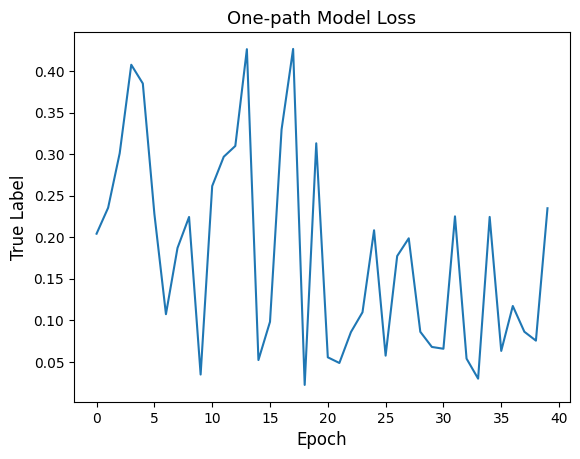

In [52]:
from matplotlib import pyplot as plt 
import seaborn as sns 
plt.plot(range(num_epochs), epoch_loss)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title('One-path Model Loss', fontsize=13)
plt.savefig("images/onepathloss", bbox_inches="tight")

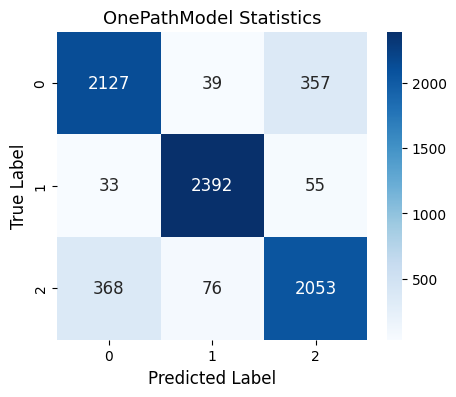

In [56]:
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(all_targets, all_predictions), annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title('OnePathModel Statistics', fontsize=13)
plt.savefig("images/onepath", bbox_inches="tight")

In [55]:
# model_path = "../../src/weights/nn_onepath.pth"

# # Save the model's state dictionary
# torch.save(model.state_dict(), model_path)

# Load trained model

In [11]:
# Load the model state dictionary
model = ClassificationModel(input_size, hidden_size, num_classes)
model.load_state_dict(torch.load("../../src/models/nn_bert_combine_v2.pth"))
model.to(device)

ClassificationModel(
  (dense1): Linear(in_features=1536, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(128, 128, batch_first=True)
  (dense2): Linear(in_features=128, out_features=3, bias=True)
)